# IMDB Binary Classification with artificial neural network
This notebook for practising binary classification with Keras library. This example is taken from *Deep Learning with Python by Françoic Chollet* (highly recommended).

In [ ]:
from keras.datasets import imdb
from keras import models, layers, regularizers
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.25)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Prepare dataset

In [ ]:
# keep only the top 10,000 most frequently occurring words
dimension = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=dimension)

In [ ]:
# train_data is a list of lists
print (train_data[0])

# train_labels is a list of int
print (train_labels[0])

In [ ]:
def vectorise_sequences(sequences, dimension=10000):
    """One-hot encode lists into vectors of 0s and 1s"""
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# vectorise input data X
X_train = vectorise_sequences(train_data, dimension=dimension)
X_test = vectorise_sequences(test_data, dimension=dimension)

In [ ]:
X_train[0]

In [ ]:
# vectorise labels y
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
X_train.shape

In [ ]:
# validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

## 2. Building network
A simple stack of fully connected layers usually perform well with binary classification problems.

1st (input) layer has 10,000 units (as specified in variable `dimension`)  
2nd layer has 16 hidden units  
3rd layer has 16 hidden units  
4th (output) layer has 1 units (outputing a probability using `sigmoid` activation function - how likely the sample is to have the target "1")

A `Dense` layer with `relu` (rectified linear unit) implements the following chain of tensor operations:  
`output = relu(dot(W, input) + b)`

In layer 2 and 3, having 16 hidden means that the weight matrix `W` will have shape 16. Therefore `dot(W, input)` will project the input data onto a 16-dimensional representation space.

The number of hidden units control the complexity of the network, hence having more hidden units can cause overfit.

The reason we need an activation function like `relu` is to introduce non-linearity. With only learning linear transformations of the input data, the *hypothesis space* of the layer would be the set of all possible linear transformations of the input data into a 16-dimensional space. Multi-layers would still implement a linear transformation. To get access to a much richer hypothesis space, we need to introduce non-linearity via an activation function.

`relu` is better than other activation functions in many cases ([see discussion here](https://datascience.stackexchange.com/questions/23493/why-relu-is-better-than-the-other-activation-functions)).

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(dimension,)))
model.add(layers.Dense(16, activation='relu'))  # no need to specify the input shape as Keras will automatically detect
model.add(layers.Dense(1, activation='sigmoid'))

To compile the model, we need to configure `optimizer`, `loss` and `metric`.  For a binary classification problem, cross-entropy is the best choice when dealing with models that output probabilities. Some might suggest using *root mean squared error (RMSE)*  (difference between the actual class label and the predicted probability), but if our goal is to minimise error rate RMSE is not an appropriate metric because a classifier misclassifies two examples can have a lower RMSE than misclassifies one example ([see discussion here](https://www.quora.com/How-is-root-mean-square-error-RMSE-and-classification-related)).

See [Keras documentation](https://keras.io/optimizers/) for `rmsprop` optimizer.

For the choice of metric, for a balanced dataset it is okay to use accuracy but for an imbalanced dataset roc_auc would be a lot more appropriate. However there is not an option in Keras for roc_auc because it cannot calculate roc_auc by mini-batches. It can only be calculate in the end of each epoch ([see discussion here](https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras)).

## 3. Train model

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 20

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=n_epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val))

## 4. Interpret model performance

In [ ]:
def plot_loss_acc(history, epochs):
    history_dict = history.history

    # loss
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    # accurancy
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(epochs, loss_values, 'bo', label='training loss')
    ax[0].plot(epochs, val_loss_values, 'b', label='validation loss')
    ax[0].set_title('Training and validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, acc_values, 'bo', label='training accuracy')
    ax[1].plot(epochs, val_acc_values, 'b', label='validation accuracy')
    ax[1].set_title('Training and validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

In [ ]:
epochs = range(1, n_epochs + 1)
plot_loss_acc(history, epochs)

As shown in the above figures, the model clearly overfits the training data as it does not perform well with the validation data. With more epochs, the validation loss increases. This means that we can reduce the number of epochs to prevent overfitting.

## 5.1 Experiment different number of hidden layers

In [ ]:
# with one hidden layer
model2 = models.Sequential()
model2.add(layers.Dense(16, activation='relu', input_shape=(dimension,)))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 20

history2 = model2.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=0)

epochs = range(1, n_epochs + 1)
print ('One hidden layer')
plot_loss_acc(history2, epochs)

In [ ]:
# with three hidden layers
model3 = models.Sequential()
model3.add(layers.Dense(16, activation='relu', input_shape=(dimension,)))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 20

history3 = model3.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=0)

epochs = range(1, n_epochs + 1)
print ('Three hidden layers')
plot_loss_acc(history3, epochs)

From the above experiment, we can see that the validation loss increases with the number of hidden layers. This is because the model has become more complex and overfits more to the training data.

## 5.2 Experiment different number of hidden units

In [ ]:
# with eight hidden units
model4 = models.Sequential()
model4.add(layers.Dense(8, activation='relu', input_shape=(dimension,)))
model4.add(layers.Dense(8, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 20

history4 = model4.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=0)

epochs = range(1, n_epochs + 1)
print ('Eight hidden units')
plot_loss_acc(history4, epochs)

In [ ]:
# with 32 hidden units
model5 = models.Sequential()
model5.add(layers.Dense(32, activation='relu', input_shape=(dimension,)))
model5.add(layers.Dense(32, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 20

history5 = model5.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=0)

epochs = range(1, n_epochs + 1)
print ('32 hidden units')
plot_loss_acc(history5, epochs)

Again, we see that with higher complexity (more hidden units) the training loss decreases whereas the validation loss increases - overfitting.

## 6. Reduce overfitting

- Reduce the capacity of the network (#epochs, #layers, #hidden units)
- Obtain more training data
- Add weight regularisation
- Add dropout

Let's use `model` as the baseline and try to improve the validation performance using the above techniques.

With dropout


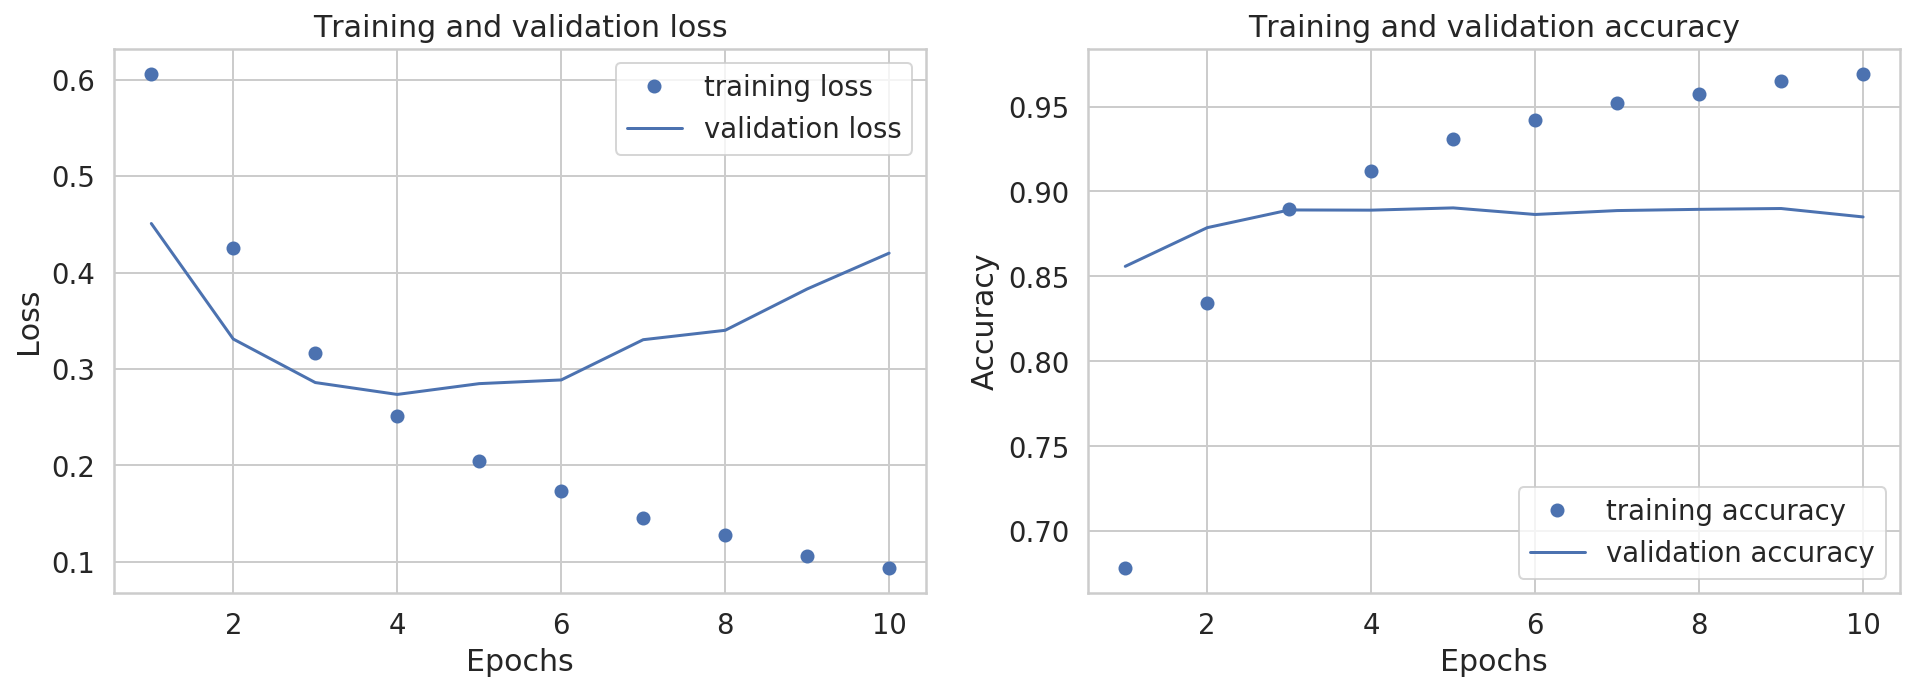

In [39]:
model6 = models.Sequential()
model6.add(layers.Dense(32, activation='relu', input_shape=(dimension,)))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(32, activation='relu'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 10

history6 = model6.fit(x=X_train,
                      y=y_train,
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=(X_val, y_val),
                      verbose=0)

epochs = range(1, n_epochs + 1)
print ('With dropout')
plot_loss_acc(history6, epochs)

## 7. Predict test set

Let's train with both train & valiation set with `model6` but with only 4 epochs. 

In [46]:
model7 = models.Sequential()
model7.add(layers.Dense(32, activation='relu', input_shape=(dimension,)))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(32, activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Dense(1, activation='sigmoid'))

model7.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['accuracy'])

n_epochs = 4

history7 = model7.fit(x=np.concatenate([X_train, X_val], axis=0),
                      y=np.concatenate([y_train, y_val], axis=0),
                      epochs=n_epochs,
                      batch_size=512,
                      validation_data=None,
                      verbose=0)

In [47]:
# return (loss value, metric values)
model7.evaluate(X_test, y_test)

25000/25000 [==============================] - 3s 124us/step


[0.290230753288269, 0.88912]

In [49]:
model7.predict(X_test)

array([[0.08818776],
       [0.99997044],
       [0.97492087],
       ...,
       [0.08450951],
       [0.04953363],
       [0.4371244 ]], dtype=float32)